## Let's get creative!

Goal:
* List out _n_ ideas/words/phrases
* Evaluate the "creativity" of the LLM by identifying how similar/dissimilar each phrase is
* Use standard NLP evaluation metrics as well as LLM-based evaluation metrics

In [1]:
import math
from abc import ABC, abstractmethod
from collections import defaultdict
from typing import Callable, List
import numpy as np
import weave
import litellm
import os
import json
import matplotlib.pyplot as plt

weave.init()

In [33]:
class SimilarityMetric(ABC):
    """Abstract base class for similarity metrics."""

    @abstractmethod
    def compute(self, item1: str, item2: str) -> float:
        """Compute the similarity between two items."""
        pass


class ExactMatchSimilarity(SimilarityMetric):
    """Checks if two strings are exactly the same."""

    def compute(self, item1: str, item2: str) -> float:
        return float(item1 == item2)

In [125]:
class PrefixMatchSimilarity(SimilarityMetric):
    """Checks if the prefixes of two strings match."""

    def __init__(self, words: List[str], prefix_length: int = 3):
        self.prefixes = self.find_common_prefixes(words)
        self.prefix_length = prefix_length

    def find_common_prefixes(self, words, min_length=3, min_occurrences=2):
        prefix_counts = defaultdict(int)
        for word in words:
            for i in range(min_length, len(word) + 1):
                prefix = word[:i]
                prefix_counts[prefix] += 1

        # Collect prefixes that meet the criteria
        common_prefixes = [
            prefix for prefix, count in prefix_counts.items() if count >= min_occurrences and len(prefix) >= min_length
        ]

        # Remove shorter prefixes that are prefixes of longer ones
        # Sort prefixes by length in descending order
        common_prefixes.sort(key=lambda x: -len(x))
        final_prefixes = []
        for prefix in common_prefixes:
            # If no longer prefix in final_prefixes starts with this prefix, add it
            if not any(p.startswith(prefix) and p != prefix for p in final_prefixes):
                final_prefixes.append(prefix)
        return final_prefixes

    def compute(self, item1: str, item2: str) -> float:
        count = 0
        if len(self.prefixes) == 0:
            return 0
        for prefix in self.prefixes:
            if (item1[: self.prefix_length] == item2[: self.prefix_length]):
                count += 1 
        return float(count / len(self.prefixes)) 


In [35]:
class LevenshteinSimilarity(SimilarityMetric):
    """Computes similarity based on Levenshtein distance."""

    def compute(self, item1: str, item2: str) -> float:
        distance = levenshtein_distance(item1, item2)
        max_len = max(len(item1), len(item2))
        if max_len == 0:
            return 1.0
        return 1 - (distance / max_len)


def levenshtein_distance(s1: str, s2: str) -> int:
    """Calculates the Levenshtein distance between two strings."""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    previous_row = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1  # Insertion
            deletions = current_row[j] + 1  # Deletion
            substitutions = previous_row[j] + (c1 != c2)  # Substitution
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

In [36]:

class SemanticSimilarity(SimilarityMetric):
    """Computes semantic similarity using embeddings."""

    def __init__(self, embedding_func: Callable[[str], np.ndarray]):
        self.embedding_func = embedding_func

    def compute(self, item1: str, item2: str) -> float:
        vec1 = self.embedding_func(item1)
        vec2 = self.embedding_func(item2)
        return cosine_similarity(vec1, vec2)


def cosine_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    """Calculates the cosine similarity between two vectors."""
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0.0
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


class CompositeSimilarity(SimilarityMetric):
    """Combines multiple similarity metrics."""

    def __init__(self, metrics: List[SimilarityMetric], weights: List[float] = None):
        self.metrics = metrics
        if weights:
            self.weights = weights
        else:
            self.weights = [1.0] * len(metrics)

    def compute(self, item1: str, item2: str) -> float:
        total_weight = sum(self.weights)
        weighted_scores = [metric.compute(item1, item2) * weight for metric, weight in zip(self.metrics, self.weights)]
        return sum(weighted_scores) / total_weight if total_weight else 0.0


def get_prefix(word, common_prefixes):
    matching_prefixes = [prefix for prefix in common_prefixes if word.lower().startswith(prefix.lower())]
    if matching_prefixes:
        return max(matching_prefixes, key=len)
    return word.split()[0]


def analyze_patterns(words):
    def find_common_prefixes(words, min_length=3, min_occurrences=2):
        prefix_counts = defaultdict(int)
        for word in words:
            for i in range(min_length, len(word) + 1):
                prefix = word[:i]
                prefix_counts[prefix] += 1

        # Collect prefixes that meet the criteria
        common_prefixes = [
            prefix for prefix, count in prefix_counts.items() if count >= min_occurrences and len(prefix) >= min_length
        ]

        # Remove shorter prefixes that are prefixes of longer ones
        common_prefixes.sort(key=lambda x: -len(x))
        final_prefixes = []
        for prefix in common_prefixes:
            if not any(p.startswith(prefix) and p != prefix for p in final_prefixes):
                final_prefixes.append(prefix)
        return final_prefixes

    def get_prefix(word, common_prefixes):
        matching_prefixes = [prefix for prefix in common_prefixes if word.lower().startswith(prefix.lower())]
        if matching_prefixes:
            return max(matching_prefixes, key=len)
        return word.split()[0]

    def find_common_suffixes(words, min_length=3, min_occurrences=2):
        suffix_counts = defaultdict(int)
        for word in words:
            for i in range(len(word) - min_length + 1):
                suffix = word[i:]
                if len(suffix) >= min_length:
                    suffix_counts[suffix] += 1

        # Collect suffixes that meet the criteria
        common_suffixes = [
            suffix for suffix, count in suffix_counts.items() if count >= min_occurrences and len(suffix) >= min_length
        ]

        # Remove shorter suffixes that are suffixes of longer ones
        common_suffixes.sort(key=lambda x: -len(x))
        final_suffixes = []
        for suffix in common_suffixes:
            if not any(s.endswith(suffix) and s != suffix for s in final_suffixes):
                final_suffixes.append(suffix)
        return final_suffixes

    def get_suffix(word, common_suffixes):
        matching_suffixes = [suffix for suffix in common_suffixes if word.lower().endswith(suffix.lower())]
        if matching_suffixes:
            return max(matching_suffixes, key=len)
        return word.split()[-1]

    # Find common prefixes
    common_prefixes = find_common_prefixes(words)

    # Extract prefixes
    prefixes = [get_prefix(word, common_prefixes) for word in words]

    # Count occurrences of each prefix
    prefix_counts = defaultdict(int)
    for prefix in prefixes:
        prefix_counts[prefix] += 1

    # Sort prefixes by their order of appearance
    unique_prefixes = sorted(set(prefixes), key=prefixes.index)

    # Calculate the prefix pattern score (higher is more patterned)
    total_words = len(words)
    unique_prefix_count = len(unique_prefixes)
    prefix_pattern_score = (total_words - unique_prefix_count) / (total_words - 1) if total_words > 1 else 0

    # Find common suffixes
    common_suffixes = find_common_suffixes(words)

    # Extract suffixes
    suffixes = [get_suffix(word, common_suffixes) for word in words]

    # Count occurrences of each suffix
    suffix_counts = defaultdict(int)
    for suffix in suffixes:
        suffix_counts[suffix] += 1

    # Sort suffixes by their order of appearance
    unique_suffixes = sorted(set(suffixes), key=suffixes.index)

    # Calculate the suffix pattern score (higher is more patterned)
    unique_suffix_count = len(unique_suffixes)
    suffix_pattern_score = (total_words - unique_suffix_count) / (total_words - 1) if total_words > 1 else 0

    # Calculate overall pattern score (average of prefix and suffix pattern scores)
    overall_pattern_score = (prefix_pattern_score + suffix_pattern_score) / 2

    # Calculate creativity score based on prefixes
    max_repetition_prefix = max(prefix_counts.values())
    max_prefix_item = max(prefix_counts, key=prefix_counts.get)
    entropy_prefix = -sum((count / total_words) * math.log2(count / total_words) for count in prefix_counts.values())
    max_entropy = math.log2(total_words)  # Maximum possible entropy
    creativity_score_prefix = (entropy_prefix / max_entropy) * (1 - (max_repetition_prefix - 1) / total_words)
    creativity_score_prefix = round(creativity_score_prefix * 100, 2)

    # Calculate creativity score based on suffixes
    max_repetition_suffix = max(suffix_counts.values())
    max_suffix_item = max(suffix_counts, key=suffix_counts.get)
    entropy_suffix = -sum((count / total_words) * math.log2(count / total_words) for count in suffix_counts.values())
    creativity_score_suffix = (entropy_suffix / max_entropy) * (1 - (max_repetition_suffix - 1) / total_words)
    creativity_score_suffix = round(creativity_score_suffix * 100, 2)

    # Calculate overall creativity score (average of prefix and suffix creativity scores)
    overall_creativity_score = round((creativity_score_prefix + creativity_score_suffix) / 2, 2)

    # Count occurrences of each word to find duplicates
    word_counts = defaultdict(int)
    for word in words:
        word_counts[word] += 1

    # Find duplicates
    duplicates = {word: count for word, count in word_counts.items() if count > 1}

    # Prepare the results
    results = {
        "prefix_counts": dict(prefix_counts),
        "prefix_order": unique_prefixes,
        "prefix_pattern_score": prefix_pattern_score,
        "creativity_score_prefix": creativity_score_prefix,
        "max_repetition_prefix": f"{max_repetition_prefix} ({max_prefix_item})",
        "common_prefixes": common_prefixes,
        "suffix_counts": dict(suffix_counts),
        "suffix_order": unique_suffixes,
        "suffix_pattern_score": suffix_pattern_score,
        "creativity_score_suffix": creativity_score_suffix,
        "max_repetition_suffix": f"{max_repetition_suffix} ({max_suffix_item})",
        "common_suffixes": common_suffixes,
        "overall_pattern_score": overall_pattern_score,
        "overall_creativity_score": overall_creativity_score,
        "duplicates": duplicates,
    }

    # Interpret the pattern scores
    def interpret_pattern_score(score):
        if score < 0.25:
            return "Low patterning: High variety."
        elif score < 0.5:
            return "Moderate patterning: Some repetition."
        elif score < 0.75:
            return "High patterning: Significant repetition."
        else:
            return "Very high patterning: Few patterns dominate."

    results["prefix_pattern_interpretation"] = interpret_pattern_score(prefix_pattern_score)
    results["suffix_pattern_interpretation"] = interpret_pattern_score(suffix_pattern_score)
    results["overall_pattern_interpretation"] = interpret_pattern_score(overall_pattern_score)

    # Interpret the creativity scores
    def interpret_creativity_score(score):
        if score < 25:
            return "Low creativity: High repetition."
        elif score < 50:
            return "Moderate creativity: Some repetition, some variety."
        elif score < 75:
            return "Good creativity: More variety, with some repetitions."
        else:
            return "High creativity: Many unique elements with few repetitions."

    results["creativity_interpretation_prefix"] = interpret_creativity_score(creativity_score_prefix)
    results["creativity_interpretation_suffix"] = interpret_creativity_score(creativity_score_suffix)
    results["overall_creativity_interpretation"] = interpret_creativity_score(overall_creativity_score)

    return results


def aggregate_semantic_similarity(strings, similarity_type="sentence_transformer"):
    """
    Calculate an aggregated semantic similarity score for a list of strings.

    Parameters:
    strings (List[str]): A list of strings to evaluate.

    Returns:
    float: The aggregated semantic similarity score between 0 and 1.
    """
    if similarity_type == "sentence_transformer":
        import numpy as np
        from sentence_transformers import SentenceTransformer
        from sklearn.metrics.pairwise import cosine_similarity

        # Load a pre-trained model for generating sentence embeddings
        model = SentenceTransformer("all-MiniLM-L6-v2")

        # Compute embeddings for each string
        embeddings = model.encode(strings)

        # Compute the cosine similarity matrix
        similarity_matrix = cosine_similarity(embeddings)

        # Calculate the average of the upper triangular part of the similarity matrix, excluding the diagonal
        n = len(strings)
        sum_similarity = np.sum(np.triu(similarity_matrix, k=1))
        num_pairs = n * (n - 1) / 2
        aggregated_score = sum_similarity / num_pairs

        return aggregated_score
    else:
        import numpy as np
        import spacy

        # Load the English language model
        nlp = spacy.load("en_core_web_sm")

        # Process all strings
        docs = [nlp(text) for text in strings]

        # Calculate pairwise similarities
        similarities = []
        for i in range(len(docs)):
            for j in range(i + 1, len(docs)):
                similarity = docs[i].similarity(docs[j])
                similarities.append(similarity)

        # Calculate the aggregated score (mean of all pairwise similarities)
        if similarities:
            aggregated_score = np.mean(similarities)
        else:
            aggregated_score = 0.0

        return aggregated_score

In [127]:
messages = [{"role": "user", 
             "content": """List 500 startup names. Return your response as a JSON as {"startup_names": [...]} DO NOT RETURN ANY OTHER ENGLISH OTHER THAN THE JSON."""}]

response = litellm.completion(model= 'gpt-4o-mini', # "claude-3-5-sonnet-20240620", 
                              messages=messages,
                              response_format={"type": "json_object" }
                             )

🍩 https://wandb.ai/reibs/creative/r/call/019216fe-9146-7811-8805-8c0d9f26eac6


In [128]:
names = json.loads(response.choices[0].message.content)['startup_names']

In [129]:
ems = ExactMatchSimilarity()

In [130]:
ems.compute(names[0], names[1])

0.0

In [131]:
def create_df(scorer, names): 
    columns = [
            [scorer.compute(name, names[i]) for i in range(len(names))]
        for name in names
    ]
    df = pd.DataFrame(columns)
    df.index = names
    df.columns = names
    return df
df = create_df(ems, names)

# Create plots
Visualize Creativity diff (order independent)

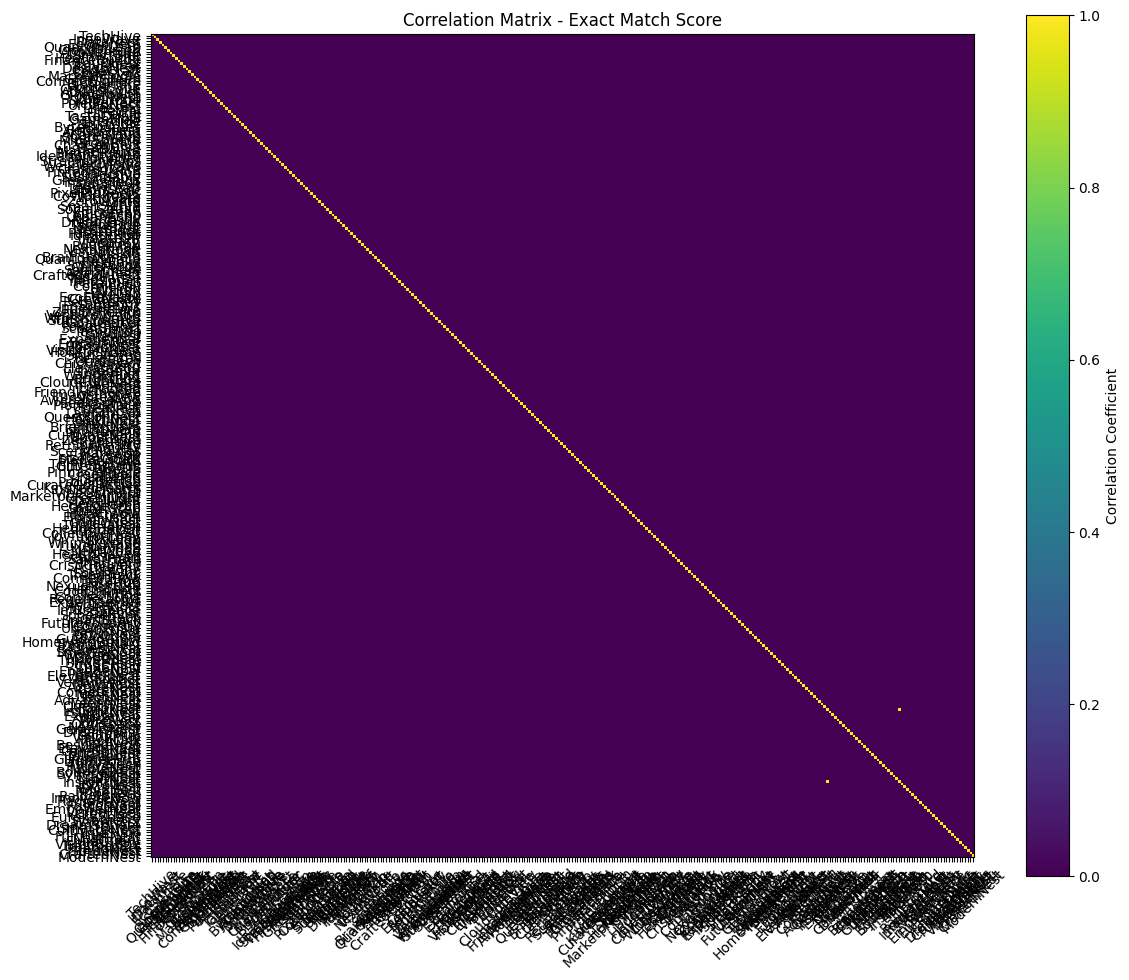

In [132]:
def plot_confusion_matrix(df, name):
    plt.figure(figsize=(12, 10))
    plt.imshow(df, interpolation='nearest')
    plt.colorbar(label='Correlation Coefficient')
    plt.xticks(range(len(df.columns)), df.columns, rotation=45)
    plt.yticks(range(len(df.columns)), df.columns)
    plt.title('Correlation Matrix - ' + name)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(df, 'Exact Match Score')

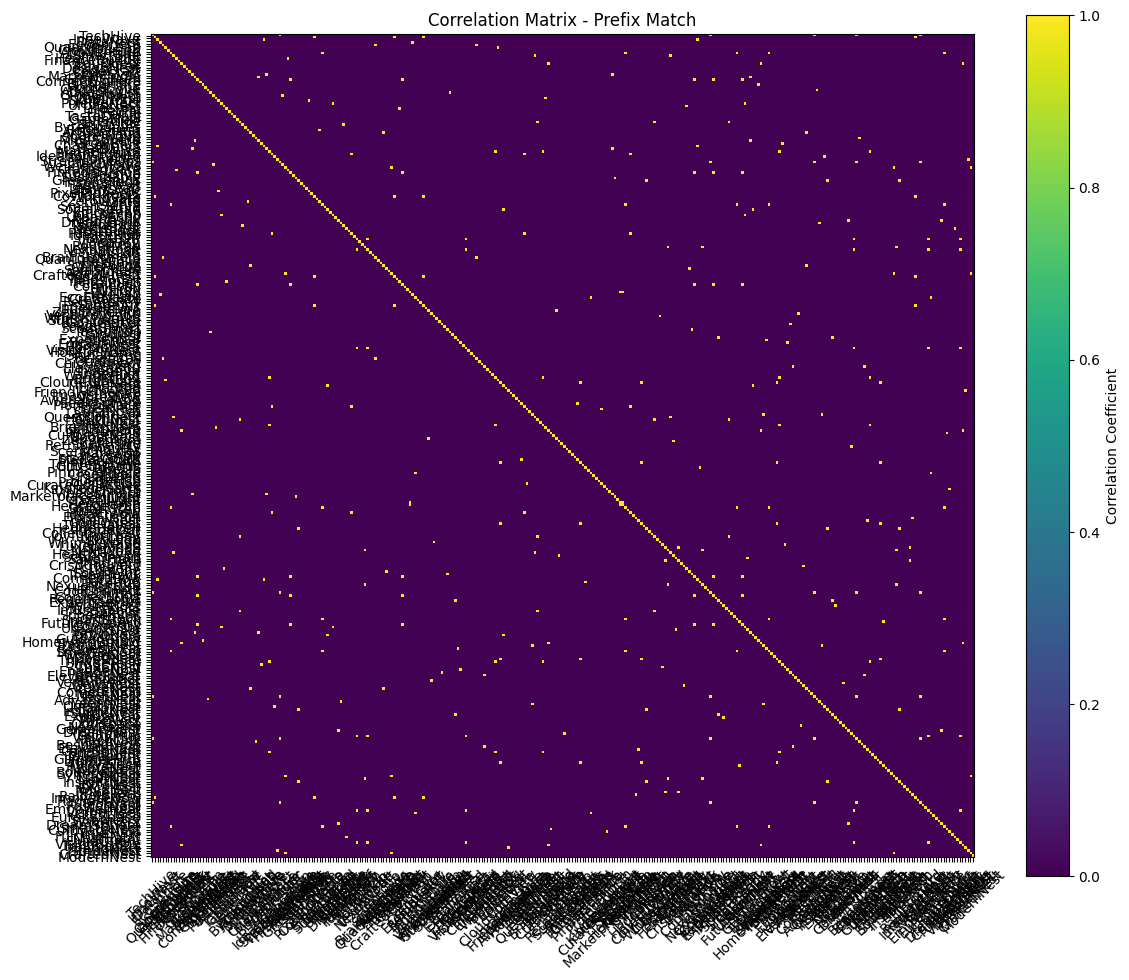

In [135]:
pms = PrefixMatchSimilarity(words=names)

df = create_df(pms, names)
plot_confusion_matrix(df, 'Prefix Match')

In [134]:
names

['TechHive',
 'InnoWave',
 'DataNest',
 'EcoSphere',
 'QuantumLeap',
 'CloudFusion',
 'AppVenture',
 'SmartBite',
 'HealthSprint',
 'FinanceBuddy',
 'EduQuest',
 'TravelTrek',
 'DesignNest',
 'CodeCraft',
 'StyleSync',
 'MarketMingle',
 'GrowGreen',
 'ConnectSphere',
 'BioNurture',
 'HomeSync',
 'CryptoCove',
 'Adventurist',
 'GigaGrowth',
 'WellNest',
 'SkillBridge',
 'PixelPerfect',
 'UrbanNest',
 'LifeSync',
 'PetPal',
 'FitForge',
 'TasteQuest',
 'GameFlow',
 'Eventide',
 'LinkLogic',
 'ByteBuddies',
 'RoboQuest',
 'ArtistryHub',
 'CareCloud',
 'Soundwave',
 'MindSphere',
 'GrowBlue',
 'ChaiConnect',
 'DataDive',
 'MarketMuse',
 'BrightFuture',
 'IdeationStation',
 'FolioFinder',
 'StreamlineOps',
 'TechTonic',
 'WellnessWave',
 'CraftedCare',
 'FinTechFusion',
 'Connective',
 'Sustainably',
 'GreenGenius',
 'InspireTech',
 'AquaNext',
 'LearnLeap',
 'SportSync',
 'PixelPioneers',
 'CoWorktopia',
 'InnoVate',
 'ZeroWaste',
 'Artify',
 'SmartServe',
 'SocialSquad',
 'Epicurean',
 'Y

In [123]:
analyze_patterns(names)

{'prefix_counts': {'InnoVibe': 1,
  'EcoVenture': 1,
  'TechNest': 1,
  'BrightBite': 1,
  'SmartHome': 1,
  'DataWave': 1,
  'HealthSphere': 1,
  'UrbanHarvest': 1,
  'SkillSync': 1,
  'FutureFolio': 1},
 'prefix_order': ['InnoVibe',
  'EcoVenture',
  'TechNest',
  'BrightBite',
  'SmartHome',
  'DataWave',
  'HealthSphere',
  'UrbanHarvest',
  'SkillSync',
  'FutureFolio'],
 'prefix_pattern_score': 0.0,
 'creativity_score_prefix': 100.0,
 'max_repetition_prefix': '1 (InnoVibe)',
 'common_prefixes': [],
 'suffix_counts': {'InnoVibe': 1,
  'EcoVenture': 1,
  'est': 2,
  'BrightBite': 1,
  'Solutions': 1,
  'DataWave': 1,
  'HealthSphere': 1,
  'SkillSync': 1,
  'FutureFolio': 1},
 'suffix_order': ['InnoVibe',
  'EcoVenture',
  'est',
  'BrightBite',
  'Solutions',
  'DataWave',
  'HealthSphere',
  'SkillSync',
  'FutureFolio'],
 'suffix_pattern_score': 0.1111111111111111,
 'creativity_score_suffix': 84.58,
 'max_repetition_suffix': '2 (est)',
 'common_suffixes': ['est'],
 'overall_patt

In [ ]:
[{{name: } for name in names}]

def create_prefix_df(patterns_dict, names): 
    columns = [
            [scorer.compute(name, names[i]) for i in range(len(names))]
        for name in names
    ]
    df = pd.DataFrame(columns)
    df.index = names
    df.columns = names
    return df
df = create_df(ems, names)

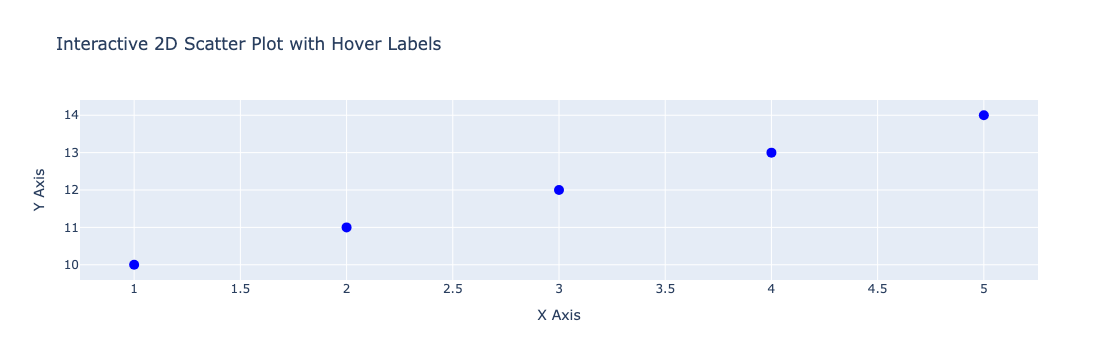

In [47]:
import plotly.graph_objs as go
import pandas as pd

# Example data
data = {
    'x': [ems.compute(n[i], n[i+1]) for i in range(len(names)-1)],
    'y': [0 for i in range(len(names)-1)],
    'labels': ['A', 'B', 'C', 'D', 'E']
}

df = pd.DataFrame(data)

# Create the scatter plot
scatter = go.Scatter(
    x=df['x'],
    y=df['y'],
    mode='markers',
    text=df['labels'],  # Labels to display on hover
    hoverinfo='text',   # Display only the label on hover
    marker=dict(size=10, color='blue')
)

# Set up layout
layout = go.Layout(
    title='Interactive 2D Scatter Plot with Hover Labels',
    xaxis=dict(title='X Axis'),
    yaxis=dict(title='Y Axis')
)

# Create the figure
fig = go.Figure(data=[scatter], layout=layout)

# Show the plot
fig.show()